In [274]:
import math
import requests, json
#from bs4 import BeautifulSoup   
import numpy as np 
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import CategoricalDtype
#from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import Pool, CatBoostRegressor
from tqdm import tqdm
from sklearn.base import clone
from sklearn.neighbors._regression import KNeighborsRegressor
from sklearn.svm._classes import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

In [275]:
RANDOM_SEED = 42


In [276]:
test_cars = pd.read_csv('test_cars.csv')
test_cars['sample'] = 1


c:\users\trigu\_skillfactory_projekts\skill_factory\project_5_auto_prices\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (11,12,16,17,19,20,32,34,35,36,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [277]:
test_cars=test_cars.drop(['car_url', 'sell_id', 'image', 'model_info',
                          'parsing_unixtime', 'priceCurrency', 'super_gen', 'vendor', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38'], axis=1)
len(test_cars.columns)

25

In [278]:
test_cars.columns

Index(['bodyType', 'brand', 'color', 'complectation_dict', 'description',
       'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType',
       'mileage', 'modelDate', 'model_name', 'name', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
       'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние',
       'Таможня', 'sample'],
      dtype='object')

In [279]:
data_par = pd.read_csv('all_auto_ru_07_12_2020-11.csv')
data_par['sample']=0

data_par=data_par.drop(['start_date', 'hidden'], axis=1)
len(data_par.columns)

26

In [280]:
data_par.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleTransmission',
       'engineDisplacement', 'vehicleConfiguration', 'enginePower',
       'description', 'mileage', 'complectation_dict', 'Привод', 'Руль',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'Состояние',
       'equipment_dict', 'model_name', 'sample'],
      dtype='object')

In [281]:
data = test_cars.append(data_par, sort=False).reset_index(drop=True)


In [282]:
data.columns =  ['bodyType', 'brand', 'color', 'complectation_dict', 'description',
       'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType',
       'mileage', 'modelDate', 'model_name', 'name', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
       'owners', 'Possession', 'PTS', 'drive_unit', 'rudder',
       'state', 'choky', 'sample', 'price']
data.head(3)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,vehicleTransmission,owners,Possession,PTS,drive_unit,rudder,state,choky,sample,price
0,лифтбек,SKODA,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,...,роботизированная,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN
1,лифтбек,SKODA,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,...,механическая,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN
2,лифтбек,SKODA,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,...,роботизированная,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN


# Тут мы парсим сайт

# Проверим датасет на наличие пропусков:

In [283]:
data.isnull().sum()

bodyType                     0
brand                        0
color                        0
complectation_dict       28268
description               7212
engineDisplacement          10
enginePower                 10
equipment_dict            9992
fuelType                     3
mileage                      0
modelDate                    0
model_name                   0
name                        11
numberOfDoors                0
productionDate               0
vehicleConfiguration        10
vehicleTransmission         10
owners                      30
Possession              155240
PTS                         35
drive_unit                  10
rudder                       0
state                   192333
choky                        0
sample                       0
price                    34690
dtype: int64

Заполним наны наиболее распостраненным значением или введём значение 'unknown' для случаев где очень много данных отсутствуют

In [284]:
nul_col=['engineDisplacement', 'enginePower', 'fuelType', 'name', 'vehicleConfiguration', 'vehicleTransmission', 'drive_unit', 'PTS', "owners" ]
for col in data[nul_col]:
    ch=data[col].value_counts().index[0]
    data[col]=data[col].fillna(ch)
unkn_col=['description', 'Possession', 'state']
for col in data[unkn_col]:
    data[col]=data[col].fillna('unknown')
    

In [285]:
data.isnull().sum()

bodyType                    0
brand                       0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9992
fuelType                    0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
owners                      0
Possession                  0
PTS                         0
drive_unit                  0
rudder                      0
state                       0
choky                       0
sample                      0
price                   34690
dtype: int64

В некоторых столбцах часто попадаются некорректно внесённые значения. Они, как правило не повторяются, поэтому можем отфильтровать их

In [286]:
columns_to_clean=['bodyType', 'brand',  'engineDisplacement',
       'enginePower',  'fuelType', 'modelDate',
       'model_name',  'numberOfDoors', 'productionDate',
       'vehicleConfiguration', 'vehicleTransmission', 'owners', 'Possession',
       'PTS', 'drive_unit', 'rudder',  'choky' ]
for col in columns_to_clean:
    
    #data_sub=data[data['sample']==1]
    data = data[data[col].isin(data[col].value_counts()[data[col].value_counts()>5].index)]

data.head(3)


,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,vehicleTransmission,owners,Possession,PTS,drive_unit,rudder,state,choky,sample,price
0,лифтбек,SKODA,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,...,роботизированная,3 или более,unknown,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN
1,лифтбек,SKODA,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,...,механическая,1 владелец,unknown,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN
2,лифтбек,SKODA,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,...,роботизированная,1 владелец,unknown,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN


In [287]:
'''
columns_to_clean_sample=['bodyType', 'brand',  'engineDisplacement',
       'enginePower',  'fuelType', 'modelDate',
       'model_name',  'numberOfDoors', 'productionDate',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня' ]
'''       

"\ncolumns_to_clean_sample=['bodyType', 'brand',  'engineDisplacement',\n       'enginePower',  'fuelType', 'modelDate',\n       'model_name',  'numberOfDoors', 'productionDate',\n       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС',\n       'Привод', 'Руль', 'Состояние', 'Таможня' ]\n"

In [288]:
'''
for col in columns_to_clean_sample:
    sample_submission = sample_submission[sample_submission[col].isin(sample_submission[col].value_counts()[sample_submission[col].value_counts()>5].index)]
sample_submission.shape  
'''

'\nfor col in columns_to_clean_sample:\n    sample_submission = sample_submission[sample_submission[col].isin(sample_submission[col].value_counts()[sample_submission[col].value_counts()>5].index)]\nsample_submission.shape  \n'

# Обработаем числовые признаки

Столбцы "enginePower" , 'name', 'engineDisplacement', 'owners' помимо нужных нам числовых знвчений содержат ненужные текстовые. Начнём с чистки этих столбцов.

In [289]:
def splitting(s):
    return str(s).split(" ")[0]
data["enginePower"]=data["enginePower"].map(lambda s: splitting(s))
data['name']=data['name'].map(lambda s: splitting(s))
data['engineDisplacement'] = data['engineDisplacement'].map(lambda s: splitting(s))
data['owners'] = data['owners'].map(lambda s: splitting(s))
#data['owners'].apply(splitting)

Некоторые признаки хоть и выглядят как числовые имеют тип стринг. Выполним преобразование. 

In [290]:
def convert_to_int(col):
    def reg_clien(stringa):
        stringa=str(stringa).strip()
        try:
            res=re.findall('\d+\.?\d+', string=str(stringa))[0]
        except: 
            res = '0'
        return res
    
    data[col] = data[col].fillna('0')
    data[col] = data[col].map(lambda a: reg_clien(a))
    data[col] = data[col].astype(np.float64)
    #data[col].astype(np.int32, inplace=True)
        


for col in ['mileage', "productionDate", "enginePower", 'name', 'engineDisplacement', 'modelDate', 'owners' ]:
    convert_to_int(col)




In [291]:
def doors(row):
    try:
        return int(row['numberOfDoors'].strip())
    except:
        return 5
data['numberOfDoors']=data.apply(lambda row:  doors(row), axis=1 )

Убедимся, что преобразование сработало:

In [292]:
for col in ['mileage', "productionDate", "enginePower", 'name', 'engineDisplacement', 'modelDate', 'owners', 'numberOfDoors' ]:
    print(data[col].dtypes)

float64
float64
float64
float64
float64
float64
float64
int64


c:\users\trigu\_skillfactory_projekts\skill_factory\project_5_auto_prices\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


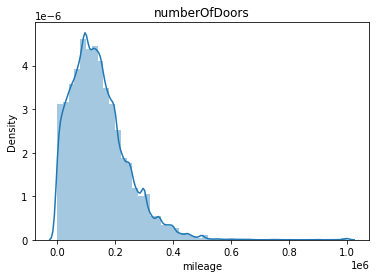

In [293]:
plt.figure()
sns.distplot(data['mileage'])
plt.title(col)
plt.show()
    

In [294]:
data['numberOfDoors'].value_counts()

5    211556
4     13087
2      1033
3       553
Name: numberOfDoors, dtype: int64

In [295]:
X_num = data[['mileage', "productionDate", "enginePower", 'name', 'engineDisplacement', 'modelDate', 'owners', 'numberOfDoors']][data['sample']==0]
X_num_sub = data[['mileage', "productionDate", "enginePower", 'name', 'engineDisplacement', 'modelDate', 'owners', 'numberOfDoors']][data['sample']==1]

# Бинарные признаки

Столбцы 'drive_unit','rudder','state', 'choky' относятся к бинарным.
Над столбцом 'PTS' нужно произвести некоторые преобразования:
    

In [296]:
data['PTS'].value_counts()

ORIGINAL     168105
Оригинал      29462
DUPLICATE     24188
Дубликат       4474
Name: PTS, dtype: int64

In [297]:
data['PTS'] = data['PTS'].str.replace('Оригинал', 'ORIGINAL')
data['PTS'] = data['PTS'].str.replace('Дубликат', 'DUPLICATE')
data['PTS'].value_counts()

ORIGINAL     197567
DUPLICATE     28662
Name: PTS, dtype: int64

In [298]:
data['rudder'] = data['rudder'].str.replace('Левый', 'LEFT')
data['rudder'] = data['rudder'].str.replace('Правый', 'RIGHT')

In [299]:
data['choky']=data['choky'].astype('str')

In [300]:
X_bin = data[['drive_unit','rudder','state',  'PTS','choky']]
#bin_cols = ['drive_unit','rudder','state',  'PTS','choky']


In [301]:
label_encoder = LabelEncoder()

for column in X_bin.columns:
    X_bin[column] = label_encoder.fit_transform(X_bin[column])
X_bin.head(3)

<ipython-input-301-6e75c4ece4d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_bin[column] = label_encoder.fit_transform(X_bin[column])


,drive_unit,rudder,state,PTS,choky
0,1,0,1,1,1
1,1,0,1,1,1
2,1,0,1,1,1


# Категориальные и бинарные признаки

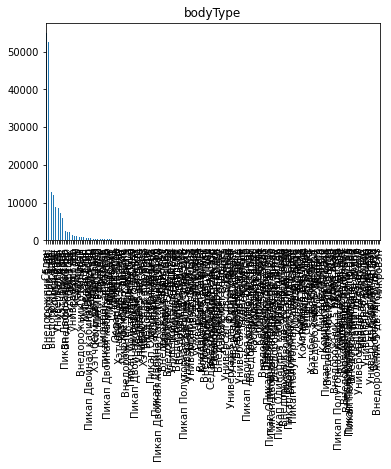

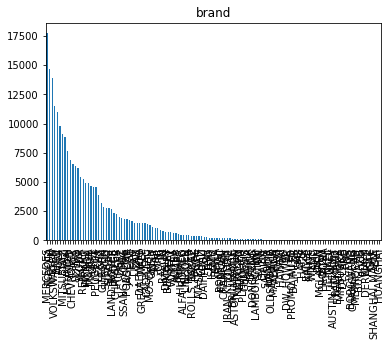

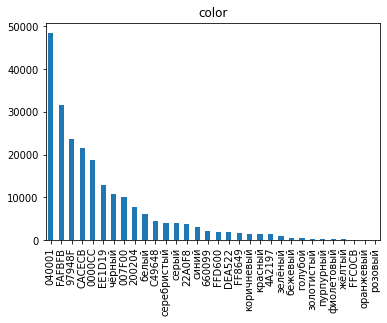

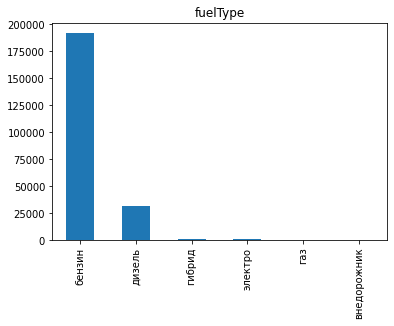

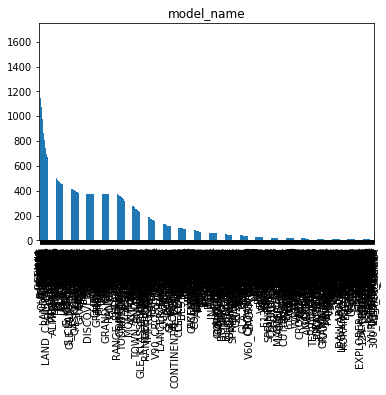

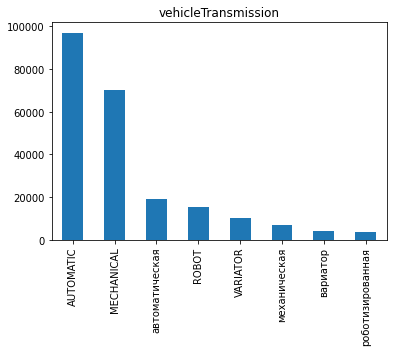

In [302]:
for col in ['bodyType', 'brand', 'color',   'fuelType', 
       'model_name',   'vehicleTransmission']:
    col_to_show=data[col].value_counts()
    col_to_show.plot(kind='bar', title=col)
    #sns.countplot(x=data[column], data=data[bin_cols])
    plt.show()

In [303]:
for col in ['bodyType', 'brand', 'color',   'fuelType', 
       'model_name',   'vehicleTransmission']:
    print('________________________')
    print(col)
    print('________________________')
    print(data[col].value_counts())

________________________
bodyType
________________________
Седан                              54909
Внедорожник 5 дв.                  52676
Хэтчбек 5 дв.                      21507
седан                              12929
внедорожник 5 дв.                  12122
                                   ...  
Универсал 5 дв. All-Terrain           10
Кабриолет Abarth                      10
Внедорожник 5 дв. 4x4                  9
Внедорожник 5 дв. Arctic Trucks        9
микровэн                               5
Name: bodyType, Length: 191, dtype: int64
________________________
brand
________________________
MERCEDES          17719
TOYOTA            14670
NISSAN            13919
VOLKSWAGEN        11521
BMW               10996
                  ...  
ARIEL                10
GAC                  10
SHANGHAI_MAPLE       10
ASIA                 10
HUANGHAI             10
Name: brand, Length: 130, dtype: int64
________________________
color
________________________
040001         48414
FAFBFB      

Признаки, имеющие не очень большое количество разных значений кодируем OneHotEncoder

In [304]:
X_cat_1=[['fuelType', 'vehicleTransmission']]

In [305]:
X_cat_1= OneHotEncoder(sparse = False).fit_transform(data[['fuelType', 'vehicleTransmission']])
X_cat_1

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

Значения остальных категориальных признаков заменим количеством их повторений в датасете.

In [306]:
X_cat_2 = data[['brand','bodyType','color','model_name']]
vc_brands = data['brand'].value_counts()
vc_body = data['bodyType'].value_counts()
vc_color = data['color'].value_counts()
vc_model =  data['model_name'].value_counts()

def encoder_br(row):
    br=row['brand']
    return vc_brands[br]

def encoder_body(row):
    bo=row['bodyType']
    return vc_body[bo]

def encoder_color(row):
    co=row['color']
    return vc_color[co]

def encoder_model(row):
    mo=row['model_name']
    return vc_model[mo]


    
X_cat_2['brand']=data.apply(lambda row: encoder_br(row), axis=1)
X_cat_2['bodyType']=data.apply(lambda row: encoder_body(row), axis=1)
X_cat_2['color']=data.apply(lambda row: encoder_color(row), axis=1)
X_cat_2['model_name']=data.apply(lambda row: encoder_model(row), axis=1)





<ipython-input-306-9d0792174984>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat_2['brand']=data.apply(lambda row: encoder_br(row), axis=1)
<ipython-input-306-9d0792174984>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat_2['bodyType']=data.apply(lambda row: encoder_body(row), axis=1)
<ipython-input-306-9d0792174984>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [307]:
X_cat_2

,brand,bodyType,color,model_name
0,5447,2208,3196,1668
1,5447,2208,10809,1668
2,5447,2208,3922,611
3,5447,2208,1487,1668
4,5447,2208,6035,1668
...,...,...,...,...
227014,2338,54909,31663,10
227015,2338,54909,31663,10
227016,2338,54909,31663,10
227017,2338,54909,31663,10


# Превратим длинные строковые значения в столбце 'equipment_dict' в списки.

In [308]:
def eq_fix(row, col):
    try:
        res= list(json.loads(row[col]).keys())
    except:
        res=[]

    return res
data['equipment_dict'] = data.apply(lambda row: eq_fix(row, 'equipment_dict'), axis=1)


Из столбца 'complectation_dict' выгрузим значения 'available_options' в json

In [309]:
def comp_fix(row, col):
    try:
        res= json.loads(row[col].replace("'", '"'))['available_options']
    except:
        res=[]

    return res

data['complectation_dict'] = data.apply(lambda row: comp_fix(row, 'complectation_dict'), axis=1)

Теперь в столбцах `equipment_dict` и `complectation_dict` расположениы списки укомплектации для каждой машины. Посмотрим какие элементы комплектации встречаются чаще всего, чтоб создать отдельные признаки опираясь на наличие этих элементов

In [310]:
equip=[]
for car in data['equipment_dict']:
    try:
        for eq in car:
            equip.append(eq)
    except:
        continue

for car in data['complectation_dict']:
    try:
        for eq in car:
            equip.append(eq)
    except:
        continue

equipment=pd.Series(equip)
equipment=equipment.value_counts()
equipment=equipment[equipment.values>10000]
equipment

lock                             43804
abs                              42969
electro-mirrors                  40539
airbag-driver                    40349
electro-window-front             40195
airbag-passenger                 39223
immo                             38254
computer                         37382
front-seats-heat                 36031
mirrors-heat                     35395
wheel-configuration1             34996
electro-window-back              33954
ptf                              33485
airbag-side                      33414
esp                              31731
wheel-power                      31447
seat-transformation              29163
wheel-configuration2             28275
audiosystem-cd                   27646
wheel-leather                    26442
multi-wheel                      25471
aux                              25464
cruise-control                   24822
audiopreparation                 24717
isofix                           24326
front-centre-armrest     

In [311]:
X_cat_3=pd.DataFrame(data['sample'])
for col in equipment.index:
    def eq_col(row):
        return int((col in row['equipment_dict']) or (col in row['complectation_dict']) )
    
    X_cat_3[col]=data.apply(lambda row: eq_col(row), axis=1)
X_cat_3_sub=pd.DataFrame(X_cat_3)
X_cat_3 = X_cat_3[X_cat_3['sample']==0]
X_cat_3_sub = X_cat_3_sub[X_cat_3_sub['sample']==1]

#### Объединяем

In [312]:
X = np.hstack([X_num, X_bin[data['sample'] == 0], X_cat_1[data['sample'] == 0], X_cat_2[data['sample']==0], X_cat_3])

X_sub = np.hstack([X_num_sub, X_bin[data['sample'] == 1], X_cat_1[data['sample'] == 1], X_cat_2[data['sample']==1], X_cat_3_sub])
X_sub.shape

(33937, 91)

Стандартизируем признаки:

In [313]:
X = StandardScaler().fit_transform(X)
X_sub = StandardScaler().fit_transform(X_sub)


In [314]:
y = data['price'][data['sample']==0]
y

34686     199000.0
34687     199000.0
34688     199000.0
34689     199000.0
34690     199000.0
            ...   
227014     45000.0
227015     45000.0
227016     45000.0
227017     45000.0
227018     45000.0
Name: price, Length: 192292, dtype: float64

Поделим выборку на тренировочную и тестовую

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Подберём модели:¶

Пробуя применять различные модели машинного обучения, я с толкнулась с тем, что получившийся датасет оказался черезчур большим и пришлось использовать его срез.

In [316]:
def split_factor(factor, X_train, y_train, X_test, y_test):
    _, X_train2, _, y_train2 = train_test_split(X_train, y_train, test_size=factor, random_state=RANDOM_SEED)
    _, X_test2, _, y_test2 = train_test_split(X_test, y_test, test_size=factor, random_state=RANDOM_SEED)
    return X_train2, y_train2, X_test2, y_test2

X_train2, y_train2, X_test2, y_test2 = split_factor(0.2, X_train, y_train, X_test, y_test)

In [317]:
Оценим уровень влияния каждой из наших фич на целевую переменную и удалим бесполезные фичи

SyntaxError: invalid syntax (<ipython-input-317-fb5b7f7d0756>, line 1)

In [ ]:
f_classif(X_train2, y_train2)
imp_num = pd.Series(f_classif(X_train2, y_train2)[0])
indexes = list()
for idx, e in enumerate(np.array(imp_num)):
    if math.isnan(e):
        indexes.append(idx)
indexes.reverse()
indexes

In [ ]:
for idx in indexes:
    X_test2 = np.delete(X_test2, idx, 1)
    X_test = np.delete(X_test, idx, 1)
    X_train2 = np.delete(X_train2, idx, 1)
    X_train = np.delete(X_train, idx, 1)
    X_sub = np.delete(X_sub, idx, 1)



Создадим универсальную функцию, с помощью которой будем создавать и тренировать данные, уменьшать датасет с заданным фактором и выводить МАPE

In [ ]:
def trait_regressor(factor, X_train, y_train, X_test, y_test, model):
    X_train_small, y_train_small, X_test_small, y_test_small = split_factor(factor, X_train, y_train, X_test, y_test)
    model.fit(X_train_small, y_train_small)
    y_pred = model.predict(X_test_small)
    print('MAPE:', np.mean(np.abs((y_test_small - y_pred) / y_test_small)) * 100)
    return model

Линейнай регрессия _иногда_ не работает, выдавая ошибку "LinAlgError: SVD did not converge in Linear Least Squares"

In [ ]:
lr_model = trait_regressor(0.26, X_train, y_train, X_test, y_test,
                              LinearRegression()
                           )

In [ ]:
rf_1 = trait_regressor(0.26, X_train, y_train, X_test, y_test,
                              RandomForestRegressor(random_state = RANDOM_SEED)
                           )

# Look at parameters used by our current forest
print('Параметры по умолчанию:\n')
pprint(rf_1.get_params())

Подберём параметры для рандом фореста

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8]
}



gridCV = GridSearchCV(estimator=rf_1, param_grid=param_grid, cv= 5)
rf_2=gridCV.fit(X_train2, y_train2)

print(gridCV.best_params_)

In [ ]:
rf_2.fit(X_train2, y_train2)
y_pred_rf_2=rf_2.predict(X_test)
print('MAPE:', np.mean(np.abs((y_test - y_pred_rf_2) / y_test)) * 100)


In [ ]:
tree = trait_regressor(0.26, X_train, y_train, X_test, y_test,
                              DecisionTreeRegressor(max_features = int(X_train2.shape[1]/3), max_depth=50)
                           )


In [ ]:
gb = trait_regressor(0.26, X_train, y_train, X_test, y_test,
               GradientBoostingRegressor( # 47.8
                    random_state = RANDOM_SEED,
                    max_depth = 11,    # 15.2
                    n_estimators = 1000 # 4.197
                )
               )

Подберём параметры для градиентного бустинга

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [800б 1000, 1200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,11,12]
}


gridCV = GridSearchCV(estimator = gb, param_grid = param_grid, cv = 5)
gb_2 = gridCV.fit(X_train2, y_train2)
print(gridCV.best_params_)


In [ ]:
gb_2.fit(X_train2, y_train2)
y_pred_gb_2 = gb_2.predict(X_test2)
print('MAPE:', np.mean(np.abs((y_test2 - y_pred_gb_2) / y_test2)) * 100)





In [ ]:
svr = trait_regressor(0.26, X_train, y_train, X_test, y_test,
               SVR()
                )

In [ ]:
knn = trait_regressor(0.26, X_train, y_train, X_test, y_test,
               KNeighborsRegressor()
               )



Catboost

In [ ]:
cbr = trait_regressor(0.26, X_train, y_train, X_test, y_test,
               CatBoostRegressor(
                        random_seed = RANDOM_SEED,
                        learning_rate = 0.05,
                        depth=9
    # iterations = 1000,
    #                      eval_metric='MAPE',
    #                      custom_metric=['R2', 'MAE']
                        )
               )

# Применим Stacking

In [ ]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros(len(y_train), dtype=np.float32)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
       # print("X_train.shape:", X_train.shape)
       # print("len(train_fold_index):",len(train_fold_index))
       # print("len(predict_fold_index):",len(predict_fold_index))
       # print("X_train.shape:", X_train.shape)
        #print('X_train[train_fold_index]', X_train[train_fold_index])
        #print('X_train[predict_fold_index]', X_train[predict_fold_index])
        
       # print("X_train:",X_train)
       # print("train_fold_index:",train_fold_index)
       # print("predict_fold_index:",predict_fold_index)
        
#X_fold_train = X_train[train_fold_index] #здесь происходит ошибка
        X_fold_train = X_train[train_fold_index]
        X_fold_predict = X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_model = clone(model)
        folded_model.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
        # print('X_meta_train', X_meta_train)
    
    meta_model = clone(model)
    meta_model.fit(X_train, y_train)
    
    X_meta_test = meta_model.predict(X_test)
    
    return X_meta_train, X_meta_test

In [ ]:
def generate_meta_features(models, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(model, X_train, X_test, y_train, cv)
        for model in tqdm(models)
    ]

    stacked_features_train = np.column_stack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.column_stack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [ ]:
cv = KFold(n_splits = 10, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestRegressor(random_state = RANDOM_SEED),
    #DecisionTreeRegressor(),
    GradientBoostingRegressor(max_depth=7,n_estimators=1000,learning_rate=0.1,random_state=RANDOM_SEED)
], X_train2, X_test2, y_train2, cv)

In [ ]:
st_stacked_features_train = stacked_features_train
# st_stacked_features_train = StandardScaler().fit_transform(stacked_features_train)
# pd.DataFrame(st_stacked_features_train).plot()
pd.DataFrame(st_stacked_features_train).plot()

In [ ]:
meta_GR = GradientBoostingRegressor()
meta_GR.fit(st_stacked_features_train, y_train2)
y_pred_meta_GR = meta_GR.predict(stacked_features_test)
print('MAPE:', np.mean(np.abs((y_test2 - y_pred_meta_GR) / y_test2)) * 100)

Попробуем, для сравнения, ещё один вариант стекинга

In [ ]:
# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LinearRegression()))
	models.append(('knn', KNeighborsRegressor()))
	models.append(('cart', DecisionTreeRegressor()))
	models.append(('svm', SVR()))
	return models

In [ ]:
# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
	# fit all models on the training set and predict on hold out set
	meta_X = list()
	for name, model in models:
		# fit in training set
		model.fit(X_train, y_train)
		# predict on hold out set
		yhat = model.predict(X_val)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store predictions as input for blending
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = np.hstack(meta_X)
	# define blending model
	blender = LinearRegression()
	# fit on predictions from base models
	blender.fit(meta_X, y_val)
	return blender

In [ ]:
# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
	# make predictions with base models
	meta_X = list()
	for name, model in models:
		# predict with base model
		yhat = model.predict(X_test)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store prediction
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = np.hstack(meta_X)
	# predict
	return blender.predict(meta_X)

In [ ]:
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X_train2, y_train2, test_size=0.5, random_state=1)
# split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=1)
# summarize data split
print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, X_test)

In [ ]:
# evaluate predictions
score = mean_absolute_error(y_test, yhat)
print('Blending MAE: %.3f' % score)

In [ ]:
print('MAPE:', np.mean(np.abs((y_test - yhat) / y_test)) * 100)


In [ ]:
X_test

In [ ]:
X_sub

# Submission

In [ ]:
predict_submission = gb.predict(X_sub)
predict_submission

In [ ]:
predict_submission

In [ ]:
sample_submission=pd.read_csv('submission00.csv')
sample_submission.shape

In [ ]:
sample_submission['price'] = predict_submission
# sample_submission['price'] = sample_submission['price'] * 0.75
sample_submission.to_csv(f'submission.csv', index=False)
sample_submission.head(10)
